In [12]:
import os
import re
import string
import random
import numpy as np
import pandas as pd
import datetime as datetime

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer 

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate,cross_val_predict,cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from unidecode import unidecode
from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import extract_unigram_feats, mark_negation

import warnings
warnings.filterwarnings('ignore')

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import emotion labelled text dataset

In [30]:
df = pd.read_csv('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Data/Input/text_emotion.csv',header=0,encoding='ISO-8859-1')
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


In [31]:
df.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [32]:
df1=df.drop(['tweet_id','author'],1)

### selecting the required sentiments

In [33]:
df1=df1.loc[df['sentiment'].isin(['worry','sadness','hate','anger','surprise','love'])]

In [34]:
df1=df1.reset_index(drop=True)

In [35]:
df1.sentiment.unique()

array(['sadness', 'worry', 'surprise', 'love', 'hate', 'anger'],
      dtype=object)

In [36]:
df1.head()

,sentiment,content
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,worry,Re-pinging @ghostridah14: why didn't you go to...
3,sadness,"I should be sleep, but im not! thinking about ..."
4,worry,Hmmm. http://www.djhero.com/ is down


### Creating Binary labels

In [37]:
temp=pd.get_dummies(df1[['sentiment']])
temp

,sentiment_anger,sentiment_hate,sentiment_love,sentiment_sadness,sentiment_surprise,sentiment_worry
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
21081,0,0,0,0,1,0
21082,0,0,1,0,0,0
21083,0,0,1,0,0,0
21084,0,0,1,0,0,0


In [38]:
df2=pd.concat([df1.content, temp], axis=1).reindex(df1.index)
df2.head(10)

,content,sentiment_anger,sentiment_hate,sentiment_love,sentiment_sadness,sentiment_surprise,sentiment_worry
0,Layin n bed with a headache ughhhh...waitin o...,0,0,0,1,0,0
1,Funeral ceremony...gloomy friday...,0,0,0,1,0,0
2,Re-pinging @ghostridah14: why didn't you go to...,0,0,0,0,0,1
3,"I should be sleep, but im not! thinking about ...",0,0,0,1,0,0
4,Hmmm. http://www.djhero.com/ is down,0,0,0,0,0,1
5,@charviray Charlene my love. I miss you,0,0,0,1,0,0
6,@kelcouch I'm sorry at least it's Friday?,0,0,0,1,0,0
7,Choked on her retainers,0,0,0,0,0,1
8,Ugh! I have to beat this stupid song to get to...,0,0,0,1,0,0
9,@BrodyJenner if u watch the hills in london u ...,0,0,0,1,0,0


### Data Pre-processing

In [39]:
ps= PorterStemmer()
stoplist = list(stopwords.words('english'))
exclude = set(string.punctuation)

In [40]:
df1['cleaned_text']=df1.content.map(lambda x : ' '.join([x.lstrip('b')]))

In [41]:
# remove @, URLs, non-alphanumeric characters,rt
df1['cleaned_text']=df1.cleaned_text.map(lambda x :''.join(re.sub("(@[\w]+)|(#)|(https?://[A-Za-z0-9./]*)|([0-9]+|\n)|([^0-9A-Za-z!? \t])|(\w+:\/\/\S+)|('rt')",'',x)).lower())

In [42]:
# remove the stopwords and punctuations
df1['cleaned_text'] = df1['cleaned_text'].map(lambda x : ' '.join([token for token\
                                       in x.split() if token.lower() not in stoplist]))
df1['cleaned_text'] = df1['cleaned_text'].map(lambda x :"".join(ch for ch in x if ch not in exclude))

In [43]:
df1.head(10)

,sentiment,content,cleaned_text
0,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin call
1,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
2,worry,Re-pinging @ghostridah14: why didn't you go to...,repinging didnt go prom bc bf didnt like friends
3,sadness,"I should be sleep, but im not! thinking about ...",sleep im not thinking old friend want hes marr...
4,worry,Hmmm. http://www.djhero.com/ is down,hmmm
5,sadness,@charviray Charlene my love. I miss you,charlene love miss
6,sadness,@kelcouch I'm sorry at least it's Friday?,im sorry least friday
7,worry,Choked on her retainers,choked retainers
8,sadness,Ugh! I have to beat this stupid song to get to...,ugh beat stupid song get next rude
9,sadness,@BrodyJenner if u watch the hills in london u ...,u watch hills london u realise tourture weeks ...


In [44]:
df1.sentiment.value_counts()

worry       8459
sadness     5165
love        3842
surprise    2187
hate        1323
anger        110
Name: sentiment, dtype: int64

### Splitting into Train and Test dataset - 70:30 randomly

In [45]:
import random
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

# create training and testing vars
y=df1.sentiment
x=df1.content
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(14760,) (14760,)
(6326,) (6326,)


### DATA MODELING

### Count-Vector Feature

In [46]:
#Importing the count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Initializing the vectorizer
count_vect = CountVectorizer(ngram_range=(1,3),max_features=10000)

count_vect.fit(X_train)

CountVectorizer(max_features=10000, ngram_range=(1, 3))

In [47]:
#print(vectorizer_i.vocabulary_)
#Transforming the words to vectors
X_train_counts_feature = count_vect.transform(X_train)
xx=count_vect.transform(df1.content)

In [48]:
#transforming the words to vectors for test set

test_cases=list(X_test)
test_cases = count_vect.transform(test_cases)
test_cases

<6326x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 95455 stored elements in Compressed Sparse Row format>

#### Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1,criterion='gini')

In [50]:
model_dt = dt.fit(X_train_counts_feature,y_train)
print('Model Score : ',model_dt.score(X_train_counts_feature,y_train))


pred_dt = model_dt.predict(test_cases)
print('Test Accuracy Score : ',metrics.accuracy_score(y_test,pred_dt))

Model Score :  0.9925474254742548
Test Accuracy Score :  0.39930445779323426


In [51]:
print(metrics.classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        25
        hate       0.27      0.23      0.25       401
        love       0.50      0.49      0.50      1197
     sadness       0.32      0.33      0.32      1509
    surprise       0.16      0.13      0.15       668
       worry       0.47      0.50      0.48      2526

    accuracy                           0.40      6326
   macro avg       0.29      0.28      0.28      6326
weighted avg       0.39      0.40      0.39      6326



#### SVM

In [52]:
from sklearn import svm
clf=svm.SVC(random_state=42)

In [53]:
model_svm = dt.fit(X_train_counts_feature,y_train)
print('Model Score : ',model_svm.score(X_train_counts_feature,y_train))


pred_svm = model_svm.predict(test_cases)
print('Test Accuracy Score : ',metrics.accuracy_score(y_test,pred_svm))

print(metrics.classification_report(y_test,pred_svm))

Model Score :  0.9925474254742548
Test Accuracy Score :  0.39930445779323426
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        25
        hate       0.27      0.23      0.25       401
        love       0.50      0.49      0.50      1197
     sadness       0.32      0.33      0.32      1509
    surprise       0.16      0.13      0.15       668
       worry       0.47      0.50      0.48      2526

    accuracy                           0.40      6326
   macro avg       0.29      0.28      0.28      6326
weighted avg       0.39      0.40      0.39      6326



#### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)

In [55]:
model_lr = lr.fit(X_train_counts_feature,y_train)
print('Model Score : ',model_lr.score(X_train_counts_feature,y_train))


pred_lr = model_lr.predict(test_cases)
print('Test Accuracy Score : ',metrics.accuracy_score(y_test,pred_lr))

print(metrics.classification_report(y_test,pred_lr))

Model Score :  0.8830623306233062
Test Accuracy Score :  0.4549478343344926
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        25
        hate       0.35      0.18      0.24       401
        love       0.61      0.56      0.58      1197
     sadness       0.35      0.34      0.35      1509
    surprise       0.22      0.13      0.16       668
       worry       0.48      0.61      0.54      2526

    accuracy                           0.45      6326
   macro avg       0.34      0.30      0.31      6326
weighted avg       0.44      0.45      0.44      6326



#### Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [57]:
model_nb = nb.fit(X_train_counts_feature,y_train)
print('Model Score : ',model_nb.score(X_train_counts_feature,y_train))


pred_nb = model_nb.predict(test_cases)
print('Test Accuracy Score : ',metrics.accuracy_score(y_test,pred_nb))

print(metrics.classification_report(y_test,pred_nb))

Model Score :  0.6902439024390243
Test Accuracy Score :  0.4715460006323111
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        25
        hate       0.36      0.12      0.19       401
        love       0.61      0.58      0.60      1197
     sadness       0.37      0.37      0.37      1509
    surprise       0.26      0.12      0.16       668
       worry       0.49      0.63      0.56      2526

    accuracy                           0.47      6326
   macro avg       0.35      0.30      0.31      6326
weighted avg       0.45      0.47      0.45      6326



#### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=42)

In [59]:
model_rf = rf.fit(X_train_counts_feature,y_train)
print('Model Score : ',model_rf.score(X_train_counts_feature,y_train))


pred_rf = model_rf.predict(test_cases)
print('Test Accuracy Score : ',metrics.accuracy_score(y_test,pred_rf))

print(metrics.classification_report(y_test,pred_rf))

Model Score :  0.9925474254742548
Test Accuracy Score :  0.4841922225735062
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        25
        hate       0.51      0.14      0.22       401
        love       0.62      0.55      0.58      1197
     sadness       0.41      0.24      0.31      1509
    surprise       0.27      0.06      0.10       668
       worry       0.47      0.77      0.58      2526

    accuracy                           0.48      6326
   macro avg       0.38      0.29      0.30      6326
weighted avg       0.46      0.48      0.44      6326



In [60]:
my_test=['I really do not know how to complete it.']

my_test=count_vect.transform(my_test)
print(model_nb.predict(my_test))

['worry']


In [51]:
#text to emotion 
import text2emotion as te

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prataprc94/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prataprc94/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/prataprc94/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
X_train

12287    Sweet booth at Newport... But all the people a...
10489    just drove by NBC's Burbank lot and the line f...
11498    @batendersblog she had another song out recent...
9587     Just had a horrible experience with a dentist....
11878    Sick of fighting so it looks like no more burl...
                               ...                        
17804                                      loviiing declan
20771             @tferriss That's very funny.  Cute kids.
16596    Loves the 2nd half of even days, orch and jazz...
19564    @lilmisssunstar will do! Tell my mommy I said ...
18552    @Tina_Marie_2009 Glad to hear you're quitting....
Name: content, Length: 14760, dtype: object

In [59]:
# analyzing the emotions of tweens and adding them to the dataframe
df1["Emotion"] = [te.get_emotion(iterator) for iterator in df1['cleaned_text']]

In [60]:
df1.head()

,sentiment,content,cleaned_text,Emotion
0,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin call,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ..."
1,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ..."
2,worry,Re-pinging @ghostridah14: why didn't you go to...,repinging didnt go prom bc bf didnt like friends,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ..."
3,sadness,"I should be sleep, but im not! thinking about ...",sleep im not thinking old friend want hes marr...,"{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.0,..."
4,worry,Hmmm. http://www.djhero.com/ is down,hmmm,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."


In [63]:
df1.Emotion[0].keys()

dict_keys(['Happy', 'Angry', 'Surprise', 'Sad', 'Fear'])

In [66]:
# analyzing the weight of each emotion for each tweet
emotion_dataframe = pd.DataFrame(df1.Emotion.values.tolist(), index=df1.index)
emotion_dataframe

,Happy,Angry,Surprise,Sad,Fear
0,0.00,0.0,0.0,0.00,1.00
1,0.00,0.0,0.0,0.00,1.00
2,1.00,0.0,0.0,0.00,0.00
3,0.33,0.0,0.0,0.67,0.00
4,0.00,0.0,0.0,0.00,0.00
...,...,...,...,...,...
21081,0.00,0.0,0.0,0.00,0.00
21082,0.25,0.0,0.0,0.50,0.25
21083,1.00,0.0,0.0,0.00,0.00
21084,0.75,0.0,0.0,0.00,0.25


In [67]:
# adding the rest of the emotions
df1["Happy"] = emotion_dataframe["Happy"]
df1["Angry"] = emotion_dataframe["Angry"]
df1["Surprise"] = emotion_dataframe["Surprise"]
df1["Sad"] = emotion_dataframe["Sad"]
df1["Fear"] = emotion_dataframe["Fear"]

In [68]:
df1['Emotion_final'] = df1[["Happy", "Angry","Surprise","Sad","Fear"]].idxmax(axis=1)

In [69]:
df1

,sentiment,content,cleaned_text,Emotion,Happy,Angry,Surprise,Sad,Fear,Emotion_final
0,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin call,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ...",0.00,0.0,0.0,0.00,1.00,Fear
1,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ...",0.00,0.0,0.0,0.00,1.00,Fear
2,worry,Re-pinging @ghostridah14: why didn't you go to...,repinging didnt go prom bc bf didnt like friends,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ...",1.00,0.0,0.0,0.00,0.00,Happy
3,sadness,"I should be sleep, but im not! thinking about ...",sleep im not thinking old friend want hes marr...,"{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.0,...",0.33,0.0,0.0,0.67,0.00,Sad
4,worry,Hmmm. http://www.djhero.com/ is down,hmmm,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':...",0.00,0.0,0.0,0.00,0.00,Happy
...,...,...,...,...,...,...,...,...,...,...
21081,surprise,@iscreamshinki Oh that's why.,oh thats,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':...",0.00,0.0,0.0,0.00,0.00,Happy
21082,love,His snoring is so annoying n it keeps me from ...,snoring annoying n keeps sleeping like right l...,"{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.0,...",0.25,0.0,0.0,0.50,0.25,Sad
21083,love,Happy Mothers Day All my love,happy mothers day love,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ...",1.00,0.0,0.0,0.00,0.00,Happy
21084,love,Happy Mother's Day to all the mommies out ther...,happy mothers day mommies woman man long youre...,"{'Happy': 0.75, 'Angry': 0.0, 'Surprise': 0.0,...",0.75,0.0,0.0,0.00,0.25,Happy


In [161]:
df1.sentiment.value_counts()

worry       8459
sadness     5165
love        3842
surprise    2187
hate        1323
anger        110
Name: sentiment, dtype: int64

In [162]:
df1.Emotion_final.value_counts()

Happy       8301
Sad         4533
Surprise    4198
Fear        3051
Angry       1003
Name: Emotion_final, dtype: int64

## Finalizing Random Forest model to classify emotions of the test tweets as it gives better train and test accuracy score compared to the other models

In [61]:
apple_df = pd.read_excel('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Data/Input/Apple_Tweets_2021.xlsx',parse_dates=[-1])
apple_df.head()

,UserName,Tweet Id,Text,Date
0,ajaykmn,1355918110612619008,@Apple @AppleSupport \n\nWould you ever respon...,2021-01-31
1,mdtefreelance,1355722510873095936,Apple has issued an urgent security update for...,2021-01-31
2,KCOLBNEK,1355583161661533952,Listen to the WHOLE PHONE call here!!! Ive bee...,2021-01-30
3,Andr3wGibbs,1355540415278161920,How To Record iPhone Screen https://t.co/8uRur...,2021-01-30
4,mbierkaa,1355206133313655040,I want to tell that Ios 14.4 is amazing in bat...,2021-01-29


In [62]:
apple_df.dtypes

UserName            object
Tweet Id             int64
Text                object
Date        datetime64[ns]
dtype: object

In [63]:
apple_df['Month'] = apple_df['Date'].apply(lambda x: x.strftime('%B'))
apple_df

,UserName,Tweet Id,Text,Date,Month
0,ajaykmn,1355918110612619008,@Apple @AppleSupport \n\nWould you ever respon...,2021-01-31,January
1,mdtefreelance,1355722510873095936,Apple has issued an urgent security update for...,2021-01-31,January
2,KCOLBNEK,1355583161661533952,Listen to the WHOLE PHONE call here!!! Ive bee...,2021-01-30,January
3,Andr3wGibbs,1355540415278161920,How To Record iPhone Screen https://t.co/8uRur...,2021-01-30,January
4,mbierkaa,1355206133313655040,I want to tell that Ios 14.4 is amazing in bat...,2021-01-29,January
...,...,...,...,...,...
43684,STANDARDfm893,1398646841131081984,📻📶 #Nowplaying on God by @LocalThy\n /w @Alo...,2021-05-29,May
43685,NiqueO9,1398646765046231040,- my life moving like a movie \n- i done seen ...,2021-05-29,May
43686,STANDARDfm893,1398646492584422912,📻📶 #Nowplaying loose control by @ThaEmmyjay\n ...,2021-05-29,May
43687,STANDARDfm893,1398646096122032128,📻📶 #Nowplaying soon by @Mista_Veeez\n /w @Al...,2021-05-29,May


In [64]:
apple_df.tail(20)

,UserName,Tweet Id,Text,Date,Month
43669,BabyJamMusic,1398654311148687104,Music enhances your self-confidence and self-e...,2021-05-29,May
43670,PayalFifty,1398653279999959040,Atiny stream for our boys !!! Both Answer and ...,2021-05-29,May
43671,Ayane_Yamazaki,1398652319315623936,【New Music Mix】\nAyane Yamazaki(山﨑彩音)\nNew Sin...,2021-05-29,May
43672,LeoDChavez,1398652077581254912,"Stream, like, follow 🤘🤘 https://t.co/us6s6bZOo...",2021-05-29,May
43673,pj4short87,1398651157959089920,AVAILABLE NOW on all streaming platforms ‼️ Fe...,2021-05-29,May
43674,LuizSantosMusic,1398651105018618112,Support &amp; BUY @iTunes https://t.co/QggD7Bl...,2021-05-29,May
43675,STANDARDfm893,1398650789623706112,📻📶 #Nowplaying Ginger me by @MeetEmmanuelIta\n...,2021-05-29,May
43676,STANDARDfm893,1398650445724271104,📻📶 #Nowplaying Ginger me by @MeetEmmanuellta\n...,2021-05-29,May
43677,ChiangLando,1398650304795536896,WOOF WOOF 👏🏻👏🏻👏🏻\nWelcome to the Pack\n\n👑👑👑👑👑...,2021-05-29,May
43678,mayorthekeed,1398648916770536960,S/O @applemusic for the playlist features \n\n...,2021-05-29,May


In [65]:
apple_df.Text[43684]

'📻📶 #Nowplaying on God by @LocalThy\n   /w @AlonsohDeejay \n\n@STANDARDfm893 #OnAir \n#afternoondelight\n#saturdayweekendVibes  #NonStopMusic \n#Tuenin #AppleMusic #BRANDNEWMUSIC 🎶📻'

In [66]:
import re
def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

In [67]:
apple_df['Text_wdt_emoji'] = apple_df['Text'].map(lambda x: remove_emojis(str(x)))

In [68]:
apple_df.tail()

,UserName,Tweet Id,Text,Date,Month,Text_wdt_emoji
43684,STANDARDfm893,1398646841131081984,📻📶 #Nowplaying on God by @LocalThy\n /w @Alo...,2021-05-29,May,#Nowplaying on God by @LocalThy\n /w @Alons...
43685,NiqueO9,1398646765046231040,- my life moving like a movie \n- i done seen ...,2021-05-29,May,- my life moving like a movie \n- i done seen ...
43686,STANDARDfm893,1398646492584422912,📻📶 #Nowplaying loose control by @ThaEmmyjay\n ...,2021-05-29,May,#Nowplaying loose control by @ThaEmmyjay\n ...
43687,STANDARDfm893,1398646096122032128,📻📶 #Nowplaying soon by @Mista_Veeez\n /w @Al...,2021-05-29,May,#Nowplaying soon by @Mista_Veeez\n /w @Alon...
43688,STANDARDfm893,1398645906157747968,📻📶 #Nowplaying Before I fall by @21way1\n /w...,2021-05-29,May,#Nowplaying Before I fall by @21way1\n /w @...


In [69]:
# remove @, URLs, non-alphanumeric characters,rt
apple_df['cleaned_text']=apple_df['Text_wdt_emoji'].map(lambda x :''.join(re.sub("(#)",' ',x)).lower())
apple_df['cleaned_text']=apple_df['cleaned_text'].map(lambda x :''.join(re.sub("(@)|(https?://[A-Za-z0-9./]*)|([0-9]+)|([^0-9A-Za-z!? \t])|(\w+:\/\/\S+)|('rt')",'',x)).lower())


In [70]:
# remove the stopwords and punctuations
apple_df['cleaned_text'] = apple_df['cleaned_text'].map(lambda x : ' '.join([token for token\
                                       in x.split() if token.lower() not in stoplist]))
apple_df['cleaned_text'] = apple_df['cleaned_text'].map(lambda x :"".join(ch for ch in x if ch not in exclude))

In [71]:
apple_df.head()

,UserName,Tweet Id,Text,Date,Month,Text_wdt_emoji,cleaned_text
0,ajaykmn,1355918110612619008,@Apple @AppleSupport \n\nWould you ever respon...,2021-01-31,January,@Apple @AppleSupport \n\nWould you ever respon...,apple applesupport would ever respond agree t...
1,mdtefreelance,1355722510873095936,Apple has issued an urgent security update for...,2021-01-31,January,Apple has issued an urgent security update for...,apple issued urgent security update ios severa...
2,KCOLBNEK,1355583161661533952,Listen to the WHOLE PHONE call here!!! Ive bee...,2021-01-30,January,Listen to the WHOLE PHONE call here!!! Ive bee...,listen whole phone call here ive support since...
3,Andr3wGibbs,1355540415278161920,How To Record iPhone Screen https://t.co/8uRur...,2021-01-30,January,How To Record iPhone Screen https://t.co/8uRur...,record iphone screen via youtube apple iphone ...
4,mbierkaa,1355206133313655040,I want to tell that Ios 14.4 is amazing in bat...,2021-01-29,January,I want to tell that Ios 14.4 is amazing in bat...,want tell ios amazing batterys consumption app...


In [73]:
apple_df.drop_duplicates(subset=['cleaned_text'],inplace=True)
apple_df.shape

(22048, 7)

In [75]:
apple_df.reset_index(inplace=True)

In [76]:
apple_df.drop('index',axis=1,inplace=True)

In [77]:
apple_df.shape

(22048, 7)

In [78]:
apple_df

,UserName,Tweet Id,Text,Date,Month,Text_wdt_emoji,cleaned_text
0,ajaykmn,1355918110612619008,@Apple @AppleSupport \n\nWould you ever respon...,2021-01-31,January,@Apple @AppleSupport \n\nWould you ever respon...,apple applesupport would ever respond agree t...
1,mdtefreelance,1355722510873095936,Apple has issued an urgent security update for...,2021-01-31,January,Apple has issued an urgent security update for...,apple issued urgent security update ios severa...
2,KCOLBNEK,1355583161661533952,Listen to the WHOLE PHONE call here!!! Ive bee...,2021-01-30,January,Listen to the WHOLE PHONE call here!!! Ive bee...,listen whole phone call here ive support since...
3,Andr3wGibbs,1355540415278161920,How To Record iPhone Screen https://t.co/8uRur...,2021-01-30,January,How To Record iPhone Screen https://t.co/8uRur...,record iphone screen via youtube apple iphone ...
4,mbierkaa,1355206133313655040,I want to tell that Ios 14.4 is amazing in bat...,2021-01-29,January,I want to tell that Ios 14.4 is amazing in bat...,want tell ios amazing batterys consumption app...
...,...,...,...,...,...,...,...
22043,TechnobuggTweet,1377258287092137984,#Realme 50W mini #SuperDart Charger Launched i...,2021-03-31,March,#Realme 50W mini #SuperDart Charger Launched i...,realme w mini superdart charger launched china...
22044,madhuyes,1377257051332603904,@b_kodiyeri @CPIMKerala @INCKerala @BJP4Kerala...,2021-03-31,March,@b_kodiyeri @CPIMKerala @INCKerala @BJP4Kerala...,bkodiyeri cpimkerala inckerala bjpkeralam thek...
22045,BNLYDS,1377256526096781056,#iPhone user blames #Apple for $600K #Bitcoin ...,2021-03-31,March,#iPhone user blames #Apple for $600K #Bitcoin ...,iphone user blames apple k bitcoin theft via f...
22046,Blessingyoung01,1377119002166586880,"music is very important, Studies show that lis...",2021-03-31,March,"music is very important, Studies show that lis...",music important studies show listening music b...


In [79]:
tests = count_vect.fit_transform(apple_df['cleaned_text'])

In [80]:
tests

<22048x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 370675 stored elements in Compressed Sparse Row format>

In [81]:
predicts = model_rf.predict(tests)

In [82]:
prediction = pd.DataFrame(predicts,columns=['Emotion'])
prediction

,Emotion
0,worry
1,love
2,sadness
3,sadness
4,worry
...,...
22043,sadness
22044,worry
22045,worry
22046,sadness


In [83]:
prediction.Emotion.value_counts()

worry       10874
sadness      6861
love         2884
surprise     1016
hate          404
anger           9
Name: Emotion, dtype: int64

In [182]:
output = pd.concat([apple_df,prediction],axis=1)
output

,UserName,Tweet Id,Text,Date,Month,Text_wdt_emoji,cleaned_text,Emotion
0,ajaykmn,1355918110612619008,@Apple @AppleSupport \n\nWould you ever respon...,2021-01-31,January,@Apple @AppleSupport \n\nWould you ever respon...,apple applesupport would ever respond agree t...,worry
1,mdtefreelance,1355722510873095936,Apple has issued an urgent security update for...,2021-01-31,January,Apple has issued an urgent security update for...,apple issued urgent security update ios severa...,surprise
2,KCOLBNEK,1355583161661533952,Listen to the WHOLE PHONE call here!!! Ive bee...,2021-01-30,January,Listen to the WHOLE PHONE call here!!! Ive bee...,listen whole phone call here ive support since...,love
3,Andr3wGibbs,1355540415278161920,How To Record iPhone Screen https://t.co/8uRur...,2021-01-30,January,How To Record iPhone Screen https://t.co/8uRur...,record iphone screen via youtube apple iphone ...,worry
4,mbierkaa,1355206133313655040,I want to tell that Ios 14.4 is amazing in bat...,2021-01-29,January,I want to tell that Ios 14.4 is amazing in bat...,want tell ios amazing batterys consumption app...,worry
...,...,...,...,...,...,...,...,...
22039,TechnobuggTweet,1377258287092137984,#Realme 50W mini #SuperDart Charger Launched i...,2021-03-31,March,#Realme 50W mini #SuperDart Charger Launched i...,realme w mini superdart charger launched china...,love
22040,madhuyes,1377257051332603904,@b_kodiyeri @CPIMKerala @INCKerala @BJP4Kerala...,2021-03-31,March,@b_kodiyeri @CPIMKerala @INCKerala @BJP4Kerala...,bkodiyeri cpimkerala inckerala bjpkeralam thek...,sadness
22041,BNLYDS,1377256526096781056,#iPhone user blames #Apple for $600K #Bitcoin ...,2021-03-31,March,#iPhone user blames #Apple for $600K #Bitcoin ...,iphone user blames apple k bitcoin theft via f...,worry
22042,Blessingyoung01,1377119002166586880,"music is very important, Studies show that lis...",2021-03-31,March,"music is very important, Studies show that lis...",music important studies show listening music b...,worry


In [184]:
output.to_excel("Output_Emotion_Detected.xlsx",index=False)

In [185]:
#importing visualization packages
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


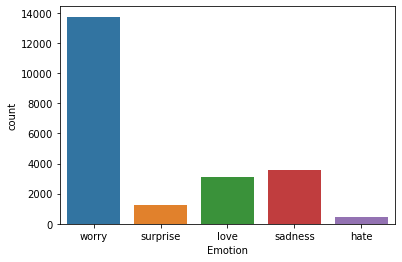

In [193]:
sns.countplot(x='Emotion', data=output )
plt.show()

# Topic Modeling

### Generating word cloud for a visual representation of the tweets

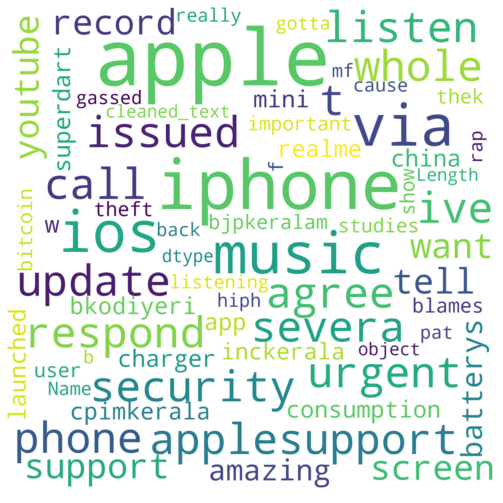

In [84]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(apple_df['cleaned_text'].dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

In [196]:
from nltk.tokenize import RegexpTokenizer,word_tokenize
tokenizer = RegexpTokenizer(r'\w+')

texts = []

for doc in apple_df['cleaned_text']:
    #print(doc)      
    tokens = [WordNetLemmatizer().lemmatize(word) for word in doc.split()]

    #tokens = tokenizer.tokenize(doc)
    pos_tagged = nltk.pos_tag(tokens)
    #print(pos_tagged)
    
    nouns_adjectives = [x for (x,y) in pos_tagged if y[0] in ['J','R','V','N']]
    
    texts.append(nouns_adjectives)
    #print(texts)

In [197]:
texts[3],apple_df.cleaned_text[3]

(['record',
  'iphone',
  'screen',
  'youtube',
  'apple',
  'iphone',
  'screenrecording',
  'screenrecord',
  'io',
  'iphonetips',
  'quicktech',
  'quicktechvideo',
  'howto',
  'tutorial',
  'techtutorial',
  'youtube',
  'apple',
  'iphonelife',
  'applesupport',
  'youtubetrends',
  'youtubecreators'],
 'record iphone screen via youtube apple iphone screenrecording screenrecord ios iphonetips quicktech quicktechvideo howto tutorial techtutorial youtube apple iphonelife applesupport youtubetrends youtubecreators')

### LDA using the Doc-term matrix

In [198]:
import gensim
from gensim import corpora,models

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(texts)
dictionary.save('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages/dictionary.dict')
print(dictionary)

Dictionary(41847 unique tokens: ['agree', 'apple', 'applesupport', 'crap', 'ever']...)


In [199]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]
corpora.MmCorpus.serialize('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//corpus.mm', doc_term_matrix)
#print(doc_term_matrix)
print (doc_term_matrix[16])

[(1, 2), (2, 1), (106, 1), (126, 1), (137, 1), (174, 1), (221, 1), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1)]


In [200]:
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

In [226]:
start = time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel_5 = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10)
ldamodel_7 = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=10)
ldamodel_10 = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=10)
print ('used time: {:.2f}s'.format(time()-start))

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


used time: 80.56s


In [223]:
def get_lda_topics(model, num_topics):
    word_dict = {}
    #topics = model.show_topics(num_topics,10)
    word_dict = {'Topic '+str(i):[x.split('*') for x in words.split('+')] \
                 for i,words in model.show_topics(num_topics,15)}
    return pd.DataFrame.from_dict(word_dict)

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [224]:
num_topics=10
topic_df = get_lda_topics(ldamodel, num_topics)
topic_df

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,"[0.043, ""applemusic"" ]","[0.086, ""iphone"" ]","[0.094, ""applemusic"" ]","[0.036, ""gt"" ]","[0.137, ""iphone"" ]","[0.020, ""doesnt"" ]","[0.102, ""applemusic"" ]","[0.033, ""w"" ]","[0.037, ""iphone"" ]","[0.073, ""icloud"" ]"
1,"[ 0.026, ""bhfyp"" ]","[ 0.083, ""io"" ]","[ 0.026, ""nowplaying"" ]","[ 0.016, ""someone"" ]","[ 0.070, ""apple"" ]","[ 0.018, ""security"" ]","[ 0.062, ""spotify"" ]","[ 0.033, ""iphone"" ]","[ 0.016, ""g"" ]","[ 0.056, ""apple"" ]"
2,"[ 0.018, ""favorite"" ]","[ 0.049, ""apple"" ]","[ 0.018, ""brandnewmusic"" ]","[ 0.014, ""thanks"" ]","[ 0.016, ""phone"" ]","[ 0.016, ""really"" ]","[ 0.057, ""music"" ]","[ 0.018, ""user"" ]","[ 0.016, ""technews"" ]","[ 0.022, ""applesupport"" ]"
3,"[ 0.017, ""christmas"" ]","[ 0.038, ""app"" ]","[ 0.018, ""tuenin"" ]","[ 0.013, ""mobile"" ]","[ 0.013, ""new"" ]","[ 0.014, ""cybersecurity"" ]","[ 0.025, ""youtube"" ]","[ 0.017, ""viral"" ]","[ 0.016, ""gadget"" ]","[ 0.012, ""photo"" ]"
4,"[ 0.014, ""live"" ]","[ 0.034, ""ipad"" ]","[ 0.018, ""standardfm"" ]","[ 0.011, ""little"" ]","[ 0.010, ""airpods"" ]","[ 0.014, ""mail"" ]","[ 0.023, ""newmusic"" ]","[ 0.013, ""bitcoin"" ]","[ 0.015, ""smartphones"" ]","[ 0.012, ""cant"" ]"
5,"[ 0.013, ""retweet"" ]","[ 0.025, ""free"" ]","[ 0.017, ""album"" ]","[ 0.009, ""right"" ]","[ 0.010, ""case"" ]","[ 0.012, ""appreciate"" ]","[ 0.022, ""itunes"" ]","[ 0.010, ""target"" ]","[ 0.015, ""innovation"" ]","[ 0.011, ""thing"" ]"
6,"[ 0.013, ""itunes"" ]","[ 0.021, ""itunes"" ]","[ 0.016, ""spotify"" ]","[ 0.009, ""claim"" ]","[ 0.009, ""tech"" ]","[ 0.012, ""fresh"" ]","[ 0.018, ""new"" ]","[ 0.010, ""favourite"" ]","[ 0.015, ""w"" ]","[ 0.010, ""get"" ]"
7,"[ 0.011, ""outnow"" ]","[ 0.012, ""appstore"" ]","[ 0.015, ""tuesdayfeeling"" ]","[ 0.009, ""station"" ]","[ 0.009, ""feature"" ]","[ 0.012, ""adding"" ]","[ 0.018, ""hiphop"" ]","[ 0.010, ""portrait"" ]","[ 0.014, ""news"" ]","[ 0.010, ""year"" ]"
8,"[ 0.010, ""life"" ]","[ 0.010, ""android"" ]","[ 0.015, ""nightmood"" ]","[ 0.009, ""swift"" ]","[ 0.008, ""android"" ]","[ 0.012, ""january"" ]","[ 0.018, ""song"" ]","[ 0.009, ""blame"" ]","[ 0.014, ""charger"" ]","[ 0.009, ""new"" ]"
9,"[ 0.009, ""make"" ]","[ 0.008, ""flip"" ]","[ 0.013, ""stream"" ]","[ 0.009, ""refurbished"" ]","[ 0.008, ""pro"" ]","[ 0.010, ""joe"" ]","[ 0.017, ""listen"" ]","[ 0.008, ""dynamic"" ]","[ 0.014, ""android"" ]","[ 0.009, ""service"" ]"


In [225]:
topic_df.to_excel('topic_10.xlsx',index=False)

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Feature vector using CountVectorizer

In [205]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [206]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def topic_model(num_topics,no_top_words,vect,df,model2):
    if vect=='count_vec':
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,analyzer='word',
                    ngram_range=(1,3),max_features=5000, stop_words='english')
    else:
        tf_vectorizer=TfidfVectorizer(use_idf=True)
             
    tf = tf_vectorizer.fit_transform(df)
    tf_feature_names = tf_vectorizer.get_feature_names()
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(tf)
    #normalize the TfIdf values so each row has unit length.
    xtfidf_norm = normalize(tfidf, norm='l1', axis=1)
    
    #return(vectorizer,countvect,xtfidf_norm)

    if model2=='nmf':
        nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
        #display_topics(nmf,tf_feature_names, no_top_words)

    elif model2=='lda':
        lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
        display_topics(lda,tf_feature_names, no_top_words)
        
    else:
        pass

In [208]:
no_top_words=15
num_topics=5
vect='count_vec'
topic_model(num_topics,no_top_words,vect,apple_df['cleaned_text'],'lda')

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:
iphone apple icloud ios ipad app applesupport new apple iphone free phone appstore iphone apple iphone ipad itunes
Topic 1:
applemusic spotify music spotify applemusic youtube itunes new newmusic applemusic spotify tidal amazonmusic single deezer soundcloud streaming
Topic 2:
hiphop rap applemusic artist music beats newmusic hiphop rap follow explorepage listen art trap newmusicalert nowplaying
Topic 3:
iphone android apple samsung tech iphone android technology smartphone mobile technews android iphone gb world apple iphone smartphones
Topic 4:
applemusic nowplaying brandnewmusic applemusic brandnewmusic tuenin applemusic standardfm tuenin tuenin applemusic brandnewmusic redbubble art onairnow standardfm onairnow bandcamp tv alonsohdeejay standardfm


In [209]:
import pyLDAvis.gensim_models
import gensim
pyLDAvis.enable_notebook()

In [228]:
ldamodel_5.save('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//topic_5.model')
ldamodel_7.save('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//topic_7.model')
ldamodel_10.save('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//topic_10.model')

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
d = gensim.corpora.Dictionary.load('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages/dictionary.dict')
c = gensim.corpora.MmCorpus('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//corpus.mm')
lda = gensim.models.LdaModel.load('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//topic_7.model')

In [213]:
from gensim.models import LdaModel
loading = LdaModel.load('/Users/prataprc94/Desktop/Sem2_Spring2022_Courses/ILS-Z 369 SMM - 36766/Assignments/paper_3/Final/Helper_packages//topic_5.model')
print(loading.print_topics(num_topics=5, num_words=15))

[(0, '0.037*"iphone" + 0.007*"photography" + 0.006*"bitcoin" + 0.005*"year" + 0.005*"important" + 0.005*"life" + 0.004*"screenshot" + 0.004*"iphoneplus" + 0.004*"also" + 0.004*"case" + 0.004*"theft" + 0.004*"heading" + 0.004*"happiness" + 0.004*"short" + 0.004*"ashesfordreams"'), (1, '0.013*"icloud" + 0.009*"iphone" + 0.007*"private" + 0.006*"launched" + 0.006*"library" + 0.006*"control" + 0.006*"mail" + 0.005*"unlock" + 0.005*"redbubble" + 0.005*"wallpaper" + 0.004*"east" + 0.004*"overall" + 0.004*"junk" + 0.004*"beta" + 0.004*"custom"'), (2, '0.085*"applemusic" + 0.044*"spotify" + 0.036*"music" + 0.016*"itunes" + 0.016*"youtube" + 0.015*"newmusic" + 0.015*"new" + 0.013*"song" + 0.012*"listen" + 0.012*"hiphop" + 0.010*"single" + 0.009*"album" + 0.009*"rap" + 0.008*"artist" + 0.008*"tidal"'), (3, '0.070*"iphone" + 0.059*"apple" + 0.025*"icloud" + 0.020*"io" + 0.011*"ipad" + 0.009*"app" + 0.008*"applesupport" + 0.008*"new" + 0.008*"phone" + 0.007*"android" + 0.006*"free" + 0.006*"user" 

/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
data = pyLDAvis.gensim_models.prepare(lda, c, d)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.209566  0.112711       1        1  26.360417
6     -0.127795 -0.369021       2        1  24.514471
3     -0.160146  0.100966       3        1  17.042296
2     -0.069387  0.134000       4        1  14.810959
0      0.149213  0.037236       5        1   6.775219
4      0.193145  0.001886       6        1   5.744201
5      0.224536 -0.017779       7        1   4.752437, topic_info=            Term          Freq         Total Category  logprob  loglift
637   applemusic   9389.000000   9389.000000  Default  30.0000  30.0000
31        iphone  11848.000000  11848.000000  Default  29.0000  29.0000
189       icloud   4088.000000   4088.000000  Default  28.0000  28.0000
5274     spotify   4321.000000   4321.000000  Default  27.0000  27.0000
1          apple   9365.000000   9365.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
575      someone    209.359579    281.819300   Topic7  -4.3250   2.7493
3213       viral    152.441771    204.416854   Topic7  -4.6423   2.7531
119    something    117.418893    208.590416   Topic7  -4.9033   2.4719
1241         add    115.233332    419.833435   Topic7  -4.9221   1.7536
271        watch     99.255802    285.751040   Topic7  -5.0713   1.9891

[335 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
727        1  0.997094           access
566        3  0.996604          account
1241       1  0.078603              add
1241       2  0.150060              add
1241       3  0.495435              add
...      ...       ...              ...
42         1  0.029718          youtube
42         2  0.925916          youtube
42         4  0.043703          youtube
5618       2  0.998403     youtubemusic
41803      4  0.994731  youtuberetweets

[435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 3, 1, 5, 6])